# Validating a trained network

In this notebook I will validate the model trained in
[Inceptionv3_21](inception_v3_experiments/Inceptionv3_21.ipynb)

In [9]:
import os
import pickle

import numpy as np

from keras import backend as K
from keras.models import model_from_json
from keras.preprocessing.image import load_img, img_to_array

from custom.tools import plot_metrics

## Image, directory, and batch setup

In [5]:
# Image dimensions:
IMG_WIDTH, IMG_HEIGHT = 299, 299

WORKING_DIR = os.getcwd()
BASE = os.path.join(WORKING_DIR, 'data', 'cars_dataset', 'keras')
SAVE_DIR = os.path.join(WORKING_DIR, 'data', 'InceptionV3')
PREDICT_DIR = os.path.join(WORKING_DIR, 'data', 'predict_me')
LOOKUP_PATH = os.path.join(SAVE_DIR, 'I_15_lookup_dict.pkl')

NB_CLASSES = 196

if K.image_data_format() == 'channels_first':
    INPUT_SHAPE = (3, IMG_WIDTH, IMG_HEIGHT)
else:
    INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

## Model definition

In [6]:
JSON_PATH = os.path.join(SAVE_DIR, 'InceptionV3_21_FT3_30_40.json')
with open (JSON_PATH, 'r') as json_file:
    loaded_model_json = json_file.read()

json_model = model_from_json(loaded_model_json)

In [7]:
WEIGHT_PATH = os.path.join(SAVE_DIR, 'InceptionV3_21_FT3_30_40.h5')
json_model.load_weights(WEIGHT_PATH)

### Predict!

In [8]:
test_file_list = [f for f in os.listdir(PREDICT_DIR) if\
                   os.path.isfile(os.path.join(PREDICT_DIR, f))]

with open(LOOKUP_PATH, 'rb') as f:
    lookup_dict = pickle.load(f)

for test_file in test_file_list:
    file_path = os.path.join(PREDICT_DIR, test_file)
    input_image = load_img(file_path, 
                           target_size=(IMG_HEIGHT, IMG_WIDTH))
    input_image = img_to_array(input_image)
    # the images are scaled during training so they need to be scaled for predictions too
    input_image = input_image/255.
    input_image = np.expand_dims(input_image, axis=0)
    prediction = json_model.predict(input_image)
    top_3 = prediction[0].argsort()[-3:][::-1]
    print('\nPredictions for {}:'.format(test_file))
    for idx in top_3:
        print(lookup_dict.get(idx))


Predictions for Dodge-Ram_Pickup_3500_Crew_Cab-2010.jpg:
Dodge-Ram_Pickup_3500_Crew_Cab-2010
Dodge-Ram_Pickup_3500_Quad_Cab-2009
Dodge-Durango_SUV-2007

Predictions for Audi-100_Sedan-1994.jpg:
Audi-100_Sedan-1994
Audi-V8_Sedan-1994
Volvo-240_Sedan-1993

Predictions for AM-General_Hummer_SUV-2000.jpg:
AM-General_Hummer_SUV-2000
HUMMER-H2_SUT_Crew_Cab-2009
HUMMER-H3T_Crew_Cab-2010

Predictions for Aston_Martin-Martin_V8_Vantage_Convertible-2012.jpg:
Aston_Martin-Martin_V8_Vantage_Convertible-2012
Aston_Martin-Martin_V8_Vantage_Coupe-2012
BMW-Z4_Convertible-2012


### Plot training and validation curves

In [11]:
# load all four training curves for the same experiment 
# (no fine tuning through 3 rounds of fine tuning)

file_name_list = ['InceptionV3_21_0_10.pkl',
                  'InceptionV3_21_FT1_10_20.pkl',
                  'InceptionV3_21_FT2_20_30.pkl',
                  'InceptionV3_21_FT3_30_40.pkl',]

summary_list = []
for file_name in file_name_list:
    file_path = os.path.join(SAVE_DIR, file_name)
    with open(file_path, 'rb') as file:
        summary = pickle.load(file)
        summary_list.append(summary)

In [20]:
key_list = ['categorical_accuracy',
            'top_3_acc',
            'top_5_acc',
            'loss']

compiled_summary = {}
for key in key_list:
    for summary in summary_list:
        val_key = 'val_' + key
        #initialize the first time
        if not compiled_summary.get(key):
            compiled_summary[key] = []
            compiled_summary[val_key] = []
        compiled_summary[key].extend(summary[key])
        compiled_summary[val_key].extend(summary[val_key])

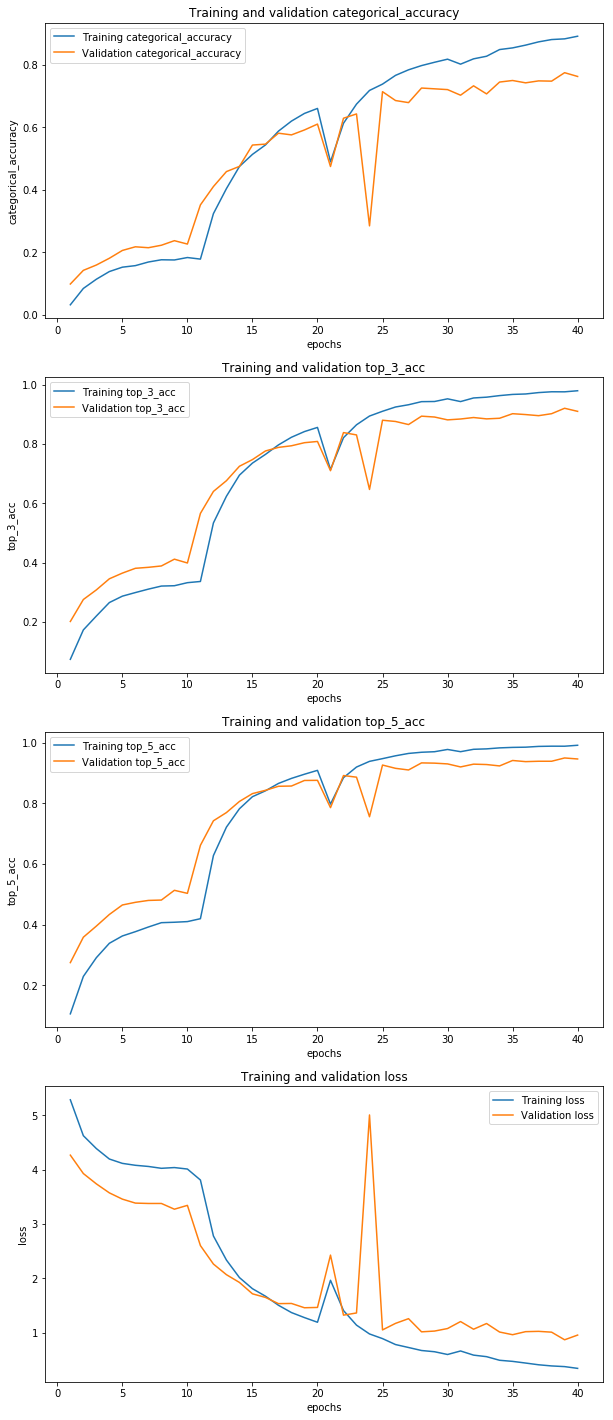

In [22]:
show = plot_metrics(compiled_summary, key_list)